In [1]:
import matplotlib.pyplot as plt
import numpy as np

% matplotlib inline

# Optimizing a stick-zeppelin tissue model

## Defining the tissue model

In [2]:
# components from dmipy that are required to define the tissuemodel outlined above
from dmipy.core.modeling_framework import MultiCompartmentModel
from dmipy.signal_models import cylinder_models, gaussian_models

# The wrapper from microtool
from microtool.dmipy import DmipyTissueModel

# Cylinder orientation angles theta, phi := mu
mu = np.array([np.pi / 2, np.pi / 2])
# Parralel diffusivity lambda_par in E-9 m^2/s (in the paper d_par)
lambda_par = 1.7e-9
lambda_perp = 0.2e-9

zeppelin = gaussian_models.G2Zeppelin(mu, lambda_par, lambda_perp)
stick = cylinder_models.C1Stick(mu, lambda_par)
stick_zeppelin = MultiCompartmentModel(models=[zeppelin, stick])
# fixing the parralel diffusivities to each other (The stick diffusivity is removed from optimization)
stick_zeppelin.set_equal_parameter('G2Zeppelin_1_lambda_par', 'C1Stick_1_lambda_par')
tissue_model = DmipyTissueModel(stick_zeppelin, volume_fractions=[0.5, 0.5])

print(tissue_model)

Tissue model with 10 scalar parameters:
Tissue-parameter            Value    Scale  Optimize    Fit    Fit Bounds
------------------------  -------  -------  ----------  -----  ------------------------------------------------
G2Zeppelin_1_mu_0         1.5708     1      True        True   (0.0, 3.141592653589793)
G2Zeppelin_1_mu_1         1.5708     1      True        True   (-3.141592653589793, 3.141592653589793)
G2Zeppelin_1_lambda_par   1.7e-09    1e-09  True        True   (1.0000000000000002e-10, 3.0000000000000004e-09)
G2Zeppelin_1_lambda_perp  2e-10      1e-09  True        True   (1.0000000000000002e-10, 3.0000000000000004e-09)
C1Stick_1_mu_0            1.5708     1      True        True   (0.0, 3.141592653589793)
C1Stick_1_mu_1            1.5708     1      True        True   (-3.141592653589793, 3.141592653589793)
C1Stick_1_lambda_par      1.7e-09    1e-09  False       True   (1.0000000000000002e-10, 3.0000000000000004e-09)
partial_volume_0          0.5        1      True        

## Defining the initial acquisition scheme

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


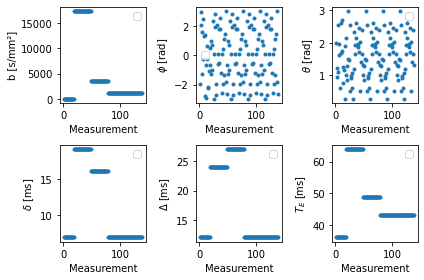

In [3]:
from microtool.utils.saved_schemes import alexander2008
from microtool.dmipy import convert_dmipy_scheme2diffusion_scheme
from microtool.utils.plotting import plot_acquisition_parameters

scheme = convert_dmipy_scheme2diffusion_scheme(alexander2008())
fig = plot_acquisition_parameters(scheme)
plt.tight_layout()
plt.show()

In [4]:
# fixing b values for b0 measurements since dmipy will freak out if you try to optimize these
scheme["DiffusionBValue"].set_fixed_mask(scheme.b_values == 0)

## The optimization procedure

In [10]:
from microtool.optimize import optimize_scheme

# The variance of the assumed gaussian noise
noise_variance = 0.02

optimal_scheme, _ = optimize_scheme(scheme, tissue_model, noise_variance, method='differential_evolution')

differential_evolution step 1: f(x)= inf
differential_evolution step 2: f(x)= inf
differential_evolution step 3: f(x)= inf
differential_evolution step 4: f(x)= inf
differential_evolution step 5: f(x)= inf
differential_evolution step 6: f(x)= inf
differential_evolution step 7: f(x)= inf
differential_evolution step 8: f(x)= inf
differential_evolution step 9: f(x)= inf
differential_evolution step 10: f(x)= inf
differential_evolution step 11: f(x)= inf
differential_evolution step 12: f(x)= inf
differential_evolution step 13: f(x)= inf
differential_evolution step 14: f(x)= inf
differential_evolution step 15: f(x)= inf
differential_evolution step 16: f(x)= inf
differential_evolution step 17: f(x)= inf
differential_evolution step 18: f(x)= inf
differential_evolution step 19: f(x)= inf
differential_evolution step 20: f(x)= inf
differential_evolution step 21: f(x)= inf
differential_evolution step 22: f(x)= inf
differential_evolution step 23: f(x)= inf
differential_evolution step 24: f(x)= inf



KeyboardInterrupt



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


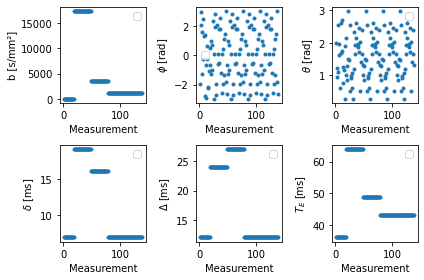

In [6]:
plot_acquisition_parameters(optimal_scheme)
plt.tight_layout()

## Verification trough Monte Carlo simulations

In [7]:
from microtool.monte_carlo import MonteCarloSimulation
from microtool.monte_carlo.parameter_distributions import plot_parameter_distributions
from scipy import stats

# Setting up noise distribution 
noise_dist = stats.norm(loc=0, scale=np.sqrt(noise_variance))

# making the monte carlo simulation
simulation = MonteCarloSimulation(scheme, tissue_model, noise_dist, n_sim=100)

# disabling dmipy's parralel processing since it is actually slower if only one voxel is fitted
simulation.set_fitting_options({"use_parallel_processing": False})

result = simulation.run()


Starting Monte Carlo with 100 simulations:   2%|▏         | 2/100 [00:13<11:17,  6.91s/it]

KeyboardInterrupt



In [ ]:
plot_parameter_distributions(result, tissue_model)
plt.tight_layout()


In [ ]:
simulation.set_scheme(optimal_scheme)
optimal_result = simulation.run()


In [ ]:
plot_parameter_distributions(optimal_result, tissue_model)
plt.tight_layout()